In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import argparse
import json
import pprint
import sys
import urllib
import urllib2

import oauth2

from collections import defaultdict

%matplotlib inline

In [34]:
API_HOST = 'api.yelp.com'
SEARCH_PATH = '/v2/search/'
BUSINESS_PATH = '/v2/business/'

with file('/Users/spardy/.config/OAUTHS/Yelp.json') as f:
    KEYS = json.load(f)

CONSUMER_KEY = KEYS['CONSUMER_KEY']
CONSUMER_SECRET = KEYS['CONSUMER_SECRET']
TOKEN = KEYS['TOKEN']
TOKEN_SECRET = KEYS['TOKEN_SECRET']


def request(host, path, url_params=None):
    """Prepares OAuth authentication and sends the request to the API.

    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        url_params (dict): An optional set of query parameters in the request.

    Returns:
        dict: The JSON response from the request.

    Raises:
        urllib2.HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = 'http://{0}{1}?'.format(host, urllib.quote(path.encode('utf8')))

    consumer = oauth2.Consumer(CONSUMER_KEY, CONSUMER_SECRET)
    oauth_request = oauth2.Request(method="GET", url=url, parameters=url_params)

    oauth_request.update(
        {
            'oauth_nonce': oauth2.generate_nonce(),
            'oauth_timestamp': oauth2.generate_timestamp(),
            'oauth_token': TOKEN,
            'oauth_consumer_key': CONSUMER_KEY
        }
    )
    token = oauth2.Token(TOKEN, TOKEN_SECRET)
    oauth_request.sign_request(oauth2.SignatureMethod_HMAC_SHA1(), consumer, token)
    signed_url = oauth_request.to_url()

    conn = urllib2.urlopen(signed_url, None)
    try:
        response = json.loads(conn.read())
    finally:
        conn.close()

    return response

def search(term, location, search_limit=20, offset=0):
    """Query the Search API by a search term and location.

    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.

    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': search_limit,
        'offset': offset
    }
    return request(API_HOST, SEARCH_PATH, url_params=url_params)



In [28]:
results = [search('Restaurant', 'Madison, WI', offset=i*20) for i in xrange(50)]

In [29]:
c = {}
for result in results:
    for business in result['businesses']:
        name = business['name']
        if name in c.keys():
            c[name] += 1
        else:
            c[name] = 1

In [2]:
dataset = []
with file('/Users/spardy/Data/yelp_academic_dataset_business.json') as f:
    for line in f:
        dataset.append(json.loads(line))

In [3]:
madison_businesses = [datum for datum in dataset if datum['city'] == 'Madison']

In [4]:
madison_restaurants = [business for business in madison_businesses if ('Restaurants' in business['categories'])]

In [35]:
stars = defaultdict(list)
for restaurant in madison_restaurants:
    categories = restaurant['categories']
    for category in categories:
        stars[category].append(restaurant['stars'])
        
all_stars = np.concatenate(stars.values())

In [6]:
from snaptools import CBcm

In [7]:
CBcm.make_color_maps()[0]['BlBu'](254)

(0.0, 0.44823529411764707, 0.69725490196078432, 1.0)

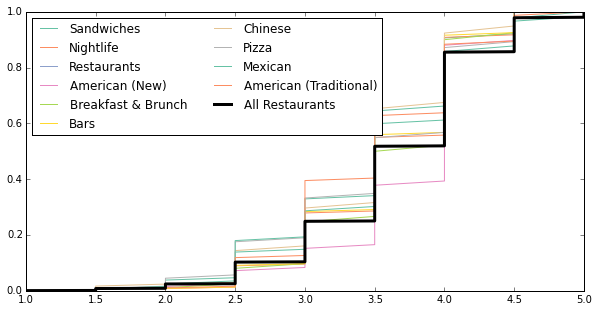

In [8]:
fig, axis = plt.subplots(1, figsize=(10, 5))

from itertools import cycle

colors = cycle(['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3'])

cutoff = 50
for i, (category, v) in enumerate(stars.iteritems()):
    if len(v) < cutoff or category == 'Food':
        continue

    axis.plot(sorted(v),
              np.cumsum(sorted(v))/np.sum(v), color=colors.next(),
              label=category)

axis.plot(sorted(stars['Restaurants']),
          np.cumsum(sorted(stars['Restaurants']))/np.sum(stars['Restaurants']),
          label='All Restaurants', color='black', linewidth=3)
    
axis.legend(loc='upper left', ncol=2)


In [12]:
len(stars['Restaurants'])

806

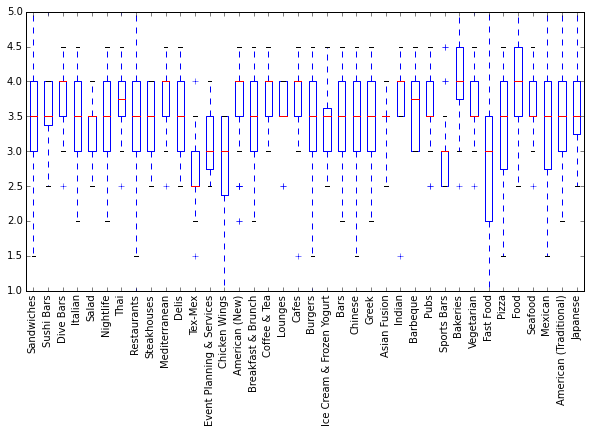

In [38]:
fig, axis = plt.subplots(1, figsize=(10, 5))

cutoff = 10

axis.boxplot([v for k, v in stars.iteritems() if len(v) > cutoff])
labels = axis.set_xticklabels([k for k, v in stars.iteritems()  if len(v) > cutoff], rotation='vertical')


In [39]:
counter = 0.  # Bonferroni Correction
pval = 0.05
for k, v in stars.iteritems():
    if len(v) < cutoff:
        continue
    counter += 1.
    print "KS for {:s}: ".format(k) +\
          "{:g}, p-value: {:g}".format(*stats.ks_2samp(sorted(v), sorted(all_stars)))
        
print "Cuttoff is : {:3.5f}".format(pval/counter)

KS for Sandwiches: 0.0977719, p-value: 0.36554
KS for Sushi Bars: 0.0679584, p-value: 0.999999
KS for Dive Bars: 0.202152, p-value: 0.614513
KS for Italian: 0.0990154, p-value: 0.722315
KS for Salad: 0.295585, p-value: 0.0843204
KS for Nightlife: 0.0489268, p-value: 0.898565
KS for Thai: 0.151292, p-value: 0.773523
KS for Restaurants: 0.0135229, p-value: 0.99985
KS for Steakhouses: 0.119849, p-value: 0.877956
KS for Mediterranean: 0.206847, p-value: 0.178822
KS for Delis: 0.062958, p-value: 0.999993
KS for Tex-Mex: 0.451272, p-value: 0.00656375
KS for Event Planning & Services: 0.318405, p-value: 0.175673
KS for Chicken Wings: 0.413233, p-value: 0.00581218
KS for American (New): 0.142323, p-value: 0.106716
KS for Breakfast & Brunch: 0.0414174, p-value: 0.999992
KS for Coffee & Tea: 0.248993, p-value: 0.0472249
KS for Lounges: 0.164112, p-value: 0.843849
KS for Cafes: 0.297294, p-value: 0.00196791
KS for Burgers: 0.110751, p-value: 0.597476
KS for Ice Cream & Frozen Yogurt: 0.163233, p-

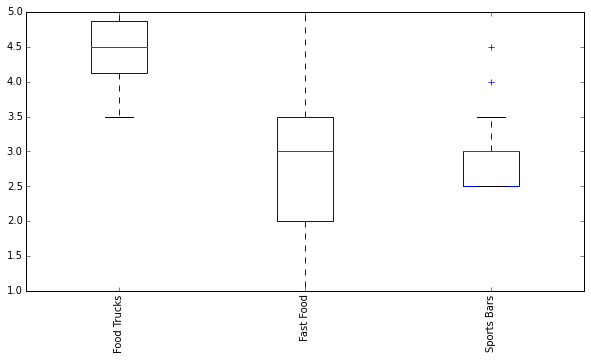

In [43]:
fig, axis = plt.subplots(1, figsize=(10, 5))

names = ['Food Trucks', 'Fast Food', 'Sports Bars']

axis.boxplot([stars[name] for name in names])
labels = axis.set_xticklabels(names, rotation='vertical')


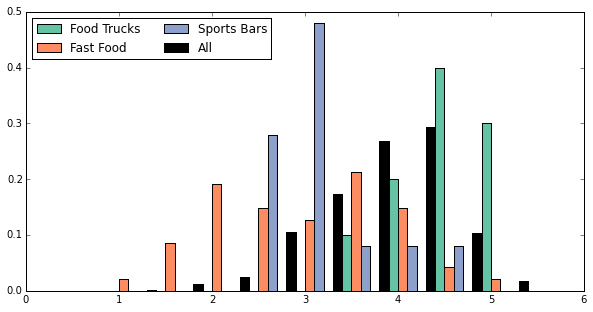

In [44]:
fig, axis = plt.subplots(1, figsize=(10, 5))

from itertools import cycle

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']

cutoff = 50
for i, name in enumerate(names):
    v = stars[name]
    hist, bins = np.histogram(v, bins=[0.9, 1.4, 1.9, 2.4, 2.9, 3.4, 3.9, 4.4, 4.9, 5.4])
    hist = hist.astype('float')/np.sum(hist)
    axis.bar(np.array([0.9, 1.4, 1.9, 2.4, 2.9, 3.4, 3.9, 4.4, 4.9])+0.10*i,
             hist, label=name, width=0.10, color=colors[i])

v = all_stars
hist, bins = np.histogram(v, bins=[0.9, 1.4, 1.9, 2.4, 2.9, 3.4, 3.9, 4.4, 4.9, 5.4])
hist = hist.astype('float')/np.sum(hist)
axis.bar(np.array([0.9, 1.4, 1.9, 2.4, 2.9, 3.4, 3.9, 4.4, 4.9])+0.10*4,
         hist, label='All', width=0.10, color='black')

axis.legend(loc='upper left', ncol=2)

In [71]:
categories = {'asian': ['Japanese', 'Korean', 'Vietnamese', 'Indonesian', 'Chinese'],
              'American': ['American', 'Pub', 'Burger'],
              'Other': ['Mexican', 'Middle Eastern']}

In [159]:
Results = {c: {subgroup: search(subgroup, 'Madison, WI') for subgroup in group} for c, group in categories.iteritems()} 
#Japanese = search('Japanese', 'Madison, WI')

Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...


In [187]:
Results_V = {}
for name, category in Results.iteritems():
    for i, (subname, subcategory) in enumerate(category.iteritems()):
        Results_V[subname] = []
        print subname
        for j, business in enumerate(subcategory['businesses']):
            Results_V[subname].append(float(business['rating']))
        print np.mean(Results_V[subname])


Burger
3.95
American
3.95
Pub
3.95
Mexican
3.85
Middle Eastern
3.875
Korean
3.66666666667
Indonesian
3.5
Japanese
3.675
Chinese
3.65
Vietnamese
3.6875


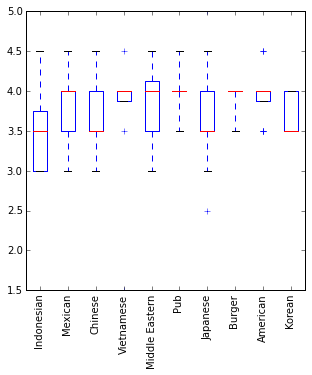

In [191]:
fig, axis = plt.subplots(1, figsize=(5, 5))

axis.boxplot([v for k, v in Results_V.iteritems()])
axis.set_xticklabels([k for k, v in Results_V.iteritems()], rotation='vertical')


In [212]:
results = {}
categories = ['Japanese', 'Korean', 'Vietnamese', 'Indonesian', 'Chinese', 'American', 'Pub', 'Burger', 'Mexican', 'Middle Eastern', 'Gastro pub']
for cat in categories:
    temp = search(cat, 'Madison, WI')
    sz = len(temp['businesses'])
    tot = temp['total']
    results[cat] = []
    for t in temp['businesses']:
        results[cat].append(t)
    for off in xrange(sz, tot, 20):
        temp = search(cat, 'Madison, WI', offset=off)
        for t in temp['businesses']:
            results[cat].append(t)
        
             

Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying h

In [216]:
results_V = {}
for name, category in results.iteritems():
    results_V[name] = []
    print name
    for j, business in enumerate(category):
        results_V[name].append(float(business['rating']))
    print np.mean(results_V[name])


Indonesian
3.5
Mexican
3.31012658228
Chinese
3.23333333333
Vietnamese
3.6875
Japanese
3.52083333333
Pub
3.56944444444
Middle Eastern
3.875
Burger
3.41329479769
American
3.41713221601
Gastro pub
3.77586206897
Korean
3.66666666667


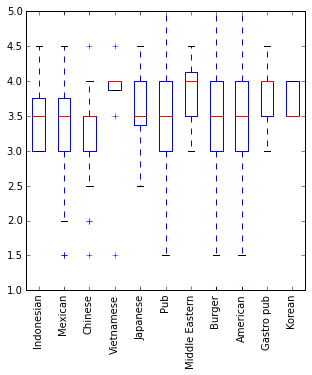

In [217]:
fig, axis = plt.subplots(1, figsize=(5, 5))

axis.boxplot([v for k, v in results_V.iteritems()])
axis.set_xticklabels([k for k, v in results_V.iteritems()], rotation='vertical')


In [222]:
results_lim = {}
categories = ['Asian', 'American']
for cat in categories:
    temp = search(cat, 'Madison, WI')
    sz = len(temp['businesses'])
    tot = temp['total']
    results_lim[cat] = []
    for t in temp['businesses']:
        results_lim[cat].append(t)
    for off in xrange(sz, tot, 20):
        temp = search(cat, 'Madison, WI', offset=off)
        for t in temp['businesses']:
            results_lim[cat].append(t)
            
results_lim_V = {}
for name, category in results_lim.iteritems():
    results_lim_V[name] = []
    print name
    for j, business in enumerate(category):
        results_lim_V[name].append(float(business['rating']))
    print np.mean(results_lim_V[name])


Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying http://api.yelp.com/v2/search/? ...
Querying h

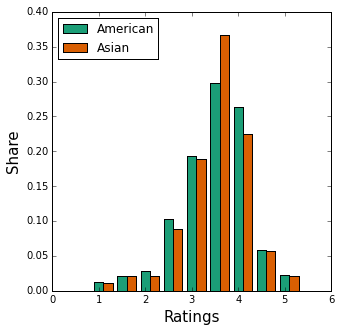

In [256]:
colors = ['#1b9e77', '#d95f02']

fig, axis = plt.subplots(1, figsize=(5, 5))
for i, (k, v) in enumerate(results_lim_V.iteritems()):
    hist, bins = np.histogram(v, bins=[0.9, 1.4, 1.9, 2.4, 2.9, 3.4, 3.9, 4.4, 4.9, 5.4])
    hist = hist.astype('float')/np.sum(hist)
    axis.bar(np.array([0.9, 1.4, 1.9, 2.4, 2.9, 3.4, 3.9, 4.4, 4.9])+0.20*i,
             hist, label=k, width=0.20, color=colors[i])
    
axis.legend(loc='upper left')
axis.set_xlabel('Ratings', fontsize=15)
axis.set_ylabel('Share', fontsize=15)
plt.savefig('Yelp_Ratings.pdf', dpi=600)

In [273]:
print "Skew: Asian: {:g}, American: {:g}".format(stats.skew(results_lim_V['Asian']),
                                                 stats.skew(results_lim_V['American']))
print "Kurtosis: Asian: {:g}, American: {:g}".format(stats.kurtosis(results_lim_V['Asian']),
                                                 stats.kurtosis(results_lim_V['American']))

Skew: Asian: -0.703284, American: -0.680704
Kurtosis: Asian: 1.35266, American: 0.903095


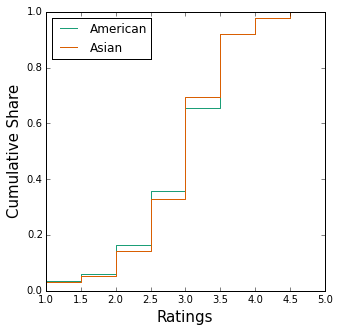

In [270]:
colors = ['#1b9e77', '#d95f02']

test_samples = {}

fig, axis = plt.subplots(1, figsize=(5, 5))
for i, (k, v) in enumerate(results_lim_V.iteritems()):
    hist, bins = np.histogram(v, bins=[0.9, 1.4, 1.9, 2.4, 2.9, 3.4, 3.9, 4.4, 4.9, 5.4])
    hist = hist.astype('float')/np.sum(hist)
    hist = np.cumsum(hist)
    test_samples[k] = hist
    axis.step([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], hist, color=colors[i], label=k)

axis.legend(loc='upper left')
axis.set_xlabel('Ratings', fontsize=15)
axis.set_ylabel('Cumulative Share', fontsize=15)
plt.savefig('Yelp_Ratings_Cumulative.pdf', dpi=600)

In [276]:
print "Test statistic: {:g}, p-value: {:g}".format(*stats.ks_2samp(test_samples['Asian'], test_samples['American']))

Test statistic: 0.111111, p-value: 1
